In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importing important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nilearn
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
# Importing Dataset

from nilearn.datasets import fetch_abide_pcp
from nilearn.connectome import ConnectivityMeasure

data = fetch_abide_pcp(derivatives=['rois_ez'], SITE_ID=['NYU']) # Extracting fMRI data from NYU repository wrt AAL atlas

In [4]:
# Pre-processing the data

conn_est = ConnectivityMeasure(kind='correlation') # Connectivity Estimator
conn_matrices = conn_est.fit_transform(data['rois_ez'])

 # Converting sym. matrix into vector
sym_vec_matrices = [conn_matrix[np.triu_indices_from(conn_matrix, k=1)] for conn_matrix in conn_matrices]# Converting sym. matrix into vector
X=sym_vec_matrices

y = data.phenotypic['DX_GROUP']
y[y == 2] = -1

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold as RSKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import StackingClassifier as SC
from sklearn.svm import SVC

>lr 0.616 (0.033)
>knn 0.605 (0.054)
>svm 0.628 (0.041)
>stacking 0.599 (0.031)


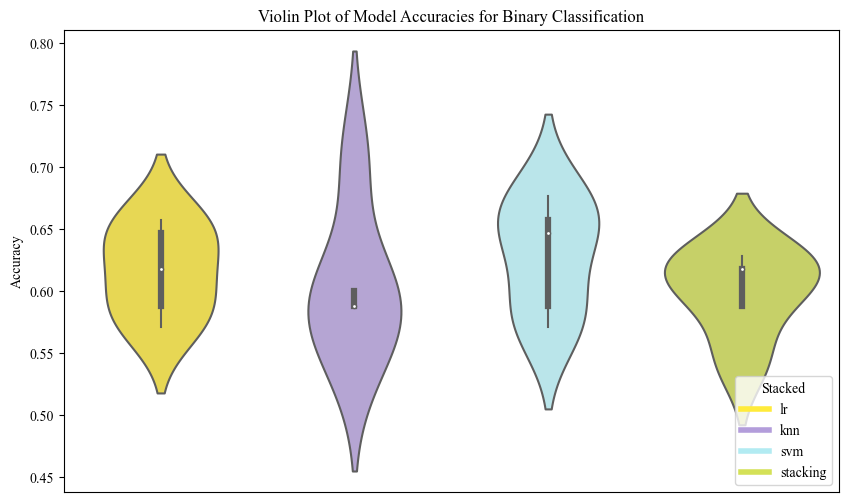

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier as SC
from sklearn.model_selection import cross_validate
from matplotlib.lines import Line2D

# Assuming X and y are your feature matrix and target variable
# You need to replace this with your actual data.

def get_stacking():
    level0 = list()
    level0.append(('lr', LR()))
    level0.append(('knn', KNN(n_neighbors=29, p=1)))
    level0.append(('svm', SVC(gamma=0.000122, C=4)))
 
    level1 = LR()
 
    model = SC(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_models():
    models = dict()
    models['lr'] = LR()
    models['knn'] = KNN(n_neighbors=29, p=1)
    models['svm'] = SVC(gamma=0.000122, C=4)
    models['stacking'] = get_stacking()
    return models

def evaluate_model(clf, X, y):
    cv_results = cross_validate(clf, X, y, cv=5)
    return cv_results['test_score']

models = get_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# Convert results to a DataFrame for easier plotting
df = pd.DataFrame(results, index=names).T

# Define a custom color palette
custom_palette = ['#FFEB3B', '#B39DDB', '#B2EBF2', '#D4E157']

# Plotting a violin plot with a custom color palette
plt.figure(figsize=(10, 6), dpi=100)
violins = sns.violinplot(data=df, palette=custom_palette)

# Add annotations to describe different parts of the violin plot


plt.title('Violin Plot of Model Accuracies for Binary Classification')
plt.ylabel('Accuracy')

# Create custom legend using Line2D objects
legend_elements = [Line2D([0], [0], color=color, lw=4, label=name) for name, color in zip(names, custom_palette)]

# Place legend in a box with the title "Stacked" in the lower right corner
plt.legend(handles=legend_elements, loc='lower right', frameon=True, title='Stacked')
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Remove x-axis labels
plt.xticks([])

plt.show()


In [7]:
def get_stacking():
	level0 = list()
	level0.append(('lr', LR()))
	level0.append(('knn', KNN(n_neighbors=29, p=1)))
	level0.append(('svm', SVC(gamma=0.000122, C=4)))
 
	level1 = LR()
 
	model = SC(estimators=level0, final_estimator=level1, cv=5)
	return model

def get_models():
	models = dict()
	models['lr'] = LR()
	models['knn'] = KNN(n_neighbors=29, p=1)
	models['svm'] = SVC(gamma=0.000122, C=4)
	models['stacking'] = get_stacking()
	return models

def evaluate_model(clf, X, y):
	cv_results = cross_validate(clf, X, y, cv=5)
	return cv_results['test_score']

>lr 0.616 (0.033)
>knn 0.605 (0.054)
>svm 0.628 (0.041)
>stacking 0.599 (0.031)
['lr', 'knn', 'svm', 'stacking']
[array([0.65714286, 0.57142857, 0.58823529, 0.64705882, 0.61764706]), array([0.6       , 0.54285714, 0.58823529, 0.70588235, 0.58823529]), array([0.57142857, 0.65714286, 0.58823529, 0.64705882, 0.67647059]), array([0.62857143, 0.54285714, 0.61764706, 0.58823529, 0.61764706])]


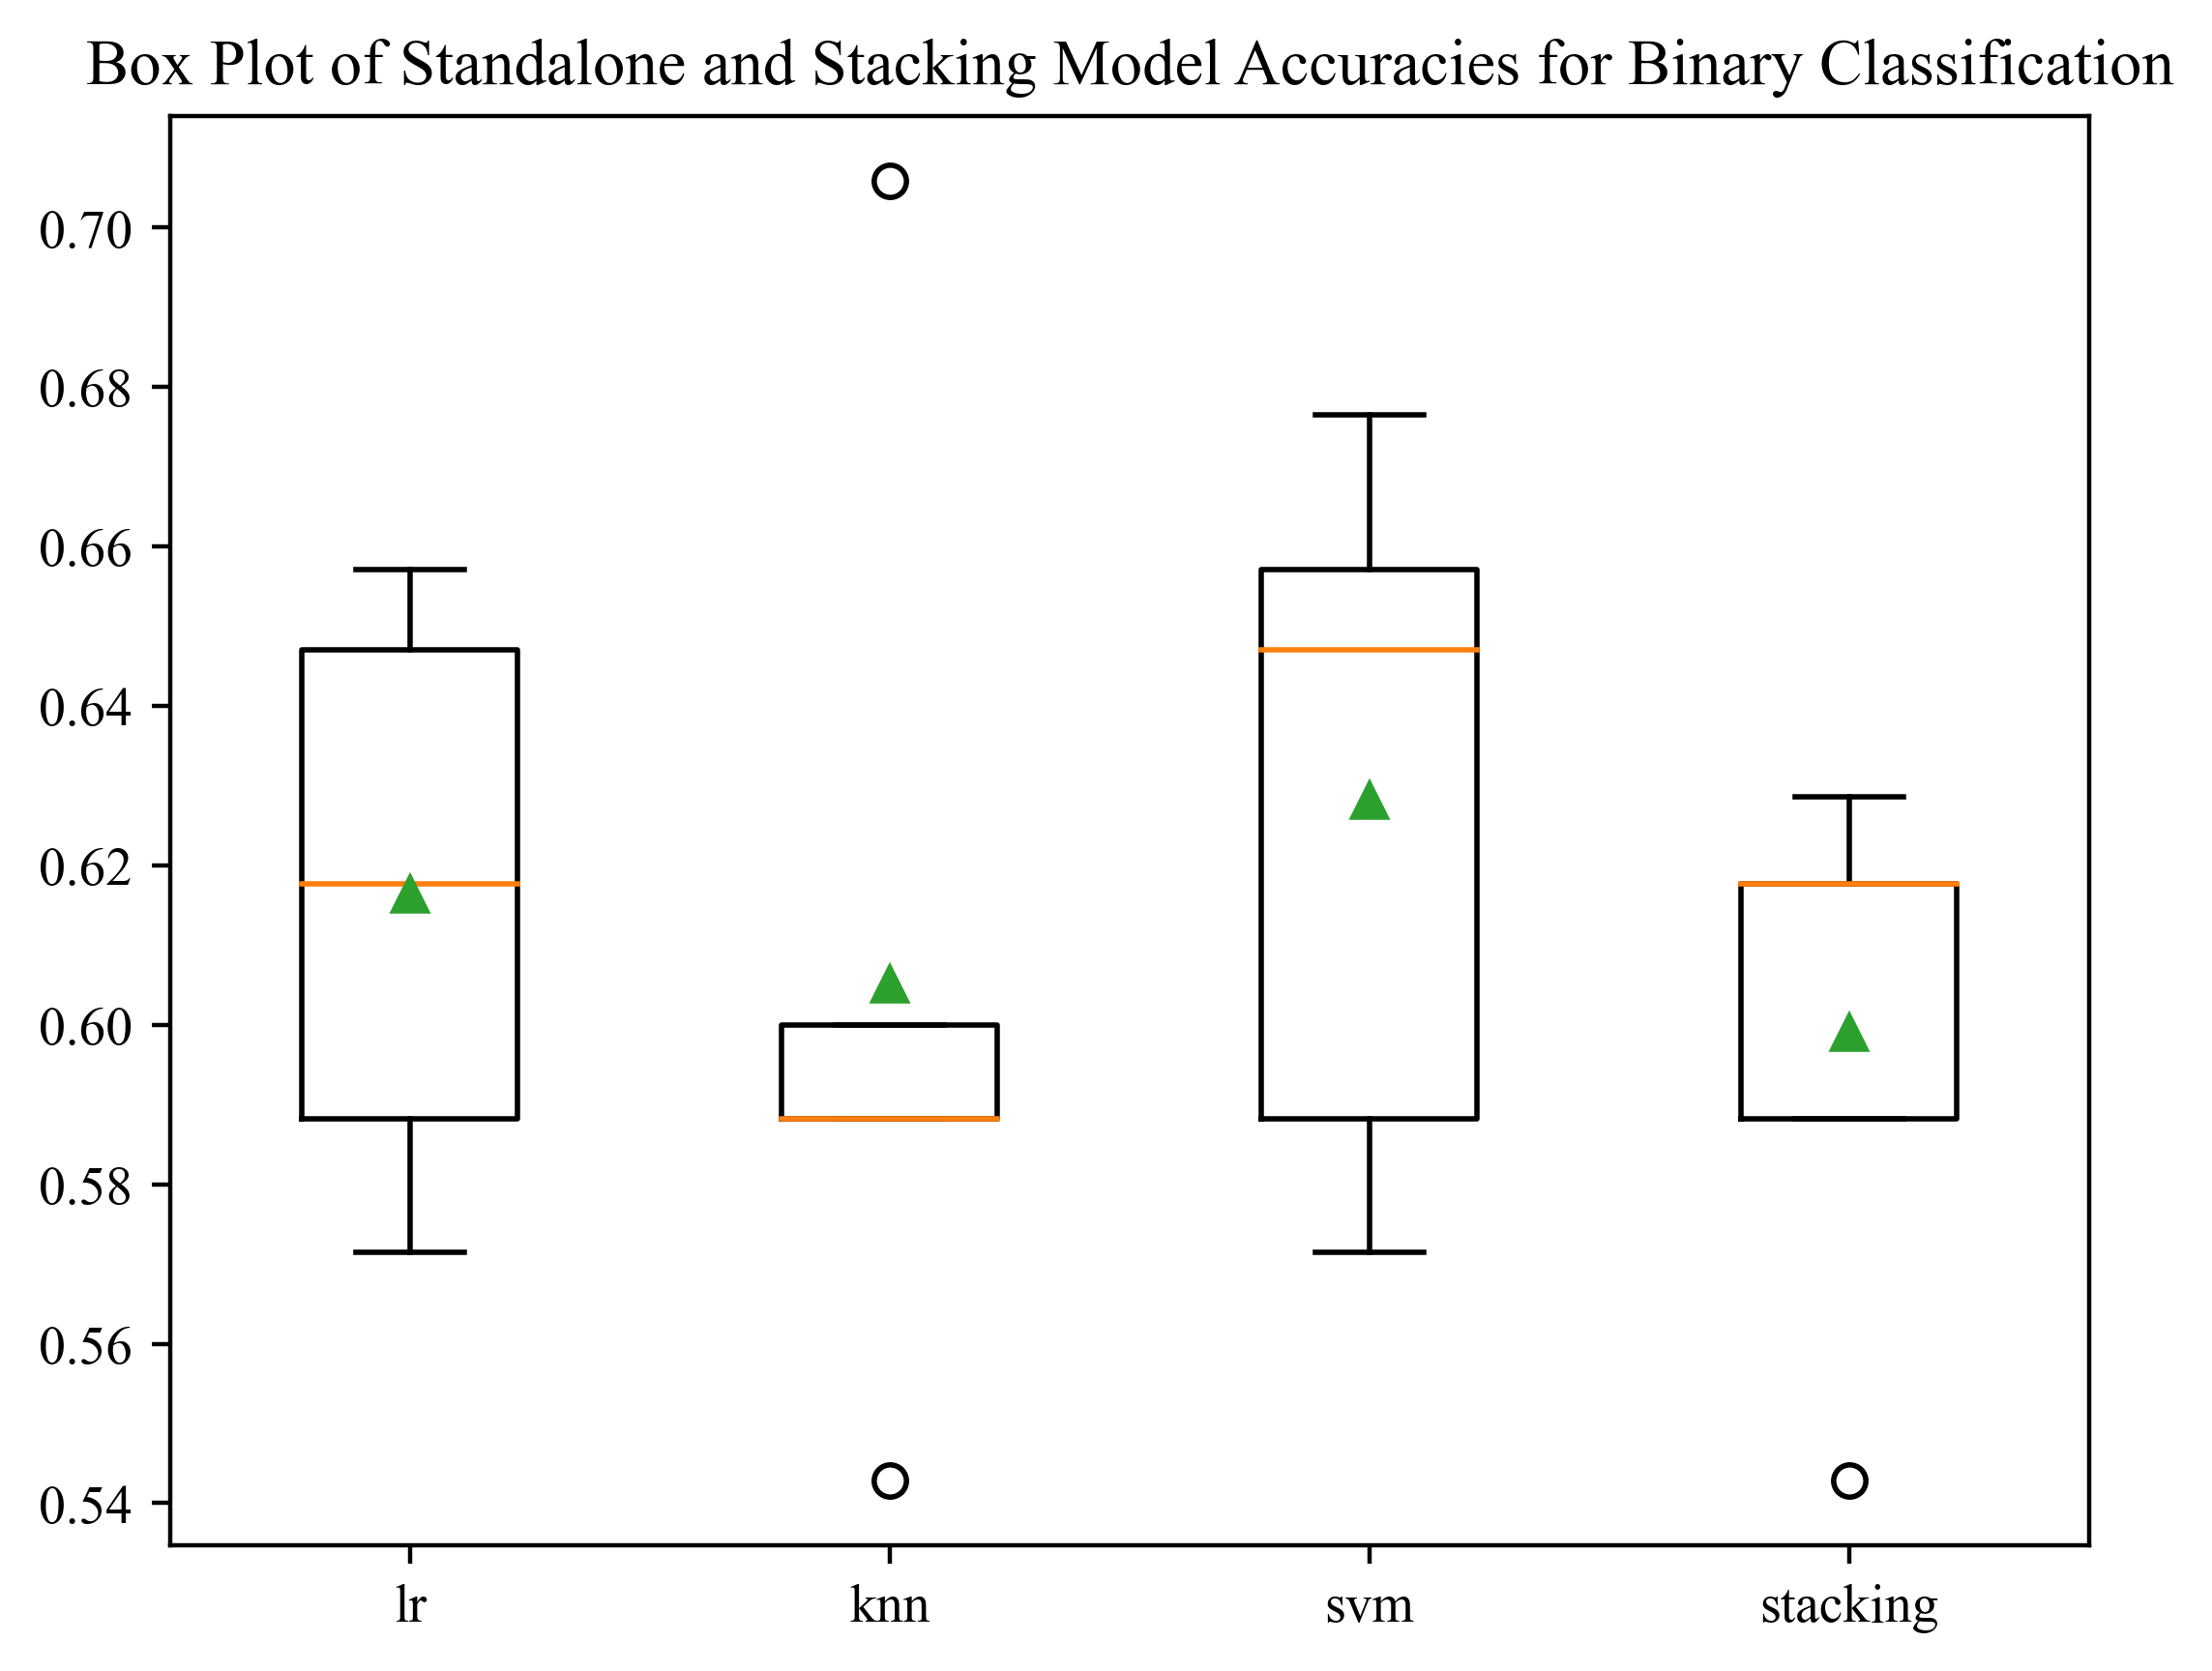

In [8]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
print(names)
print(results)
plt.figure(dpi=400)
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Box Plot of Standalone and Stacking Model Accuracies for Binary Classification')
plt.show()